In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, classification_report

from mpl_toolkits.axes_grid1 import make_axes_locatable

# **AA UTILS**

In [46]:
def if_dataframe_to_numpy(data):
    return data.to_numpy() if isinstance(data, pd.DataFrame) or isinstance(data, pd.Series) else data

def plot_2d(modelo, X, X_train, X_test, y_train, y_test, boundry_function):

    assert X.shape[1] == 2, f"X debe tener solo dos variables de entrada (tiene {X.shape[1]})"

    X = if_dataframe_to_numpy(X)
    X_train = if_dataframe_to_numpy(X_train)
    X_test = if_dataframe_to_numpy(X_test)

    plt.figure()
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    Z = np.c_[xx.ravel(), yy.ravel()]
    Z = boundry_function(modelo, Z)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.colorbar()

    plt.scatter(X_train[:, 0], X_train[:, 1], marker="o", c=y_train, label='Training')
    plt.scatter(X_test[:, 0], X_test[:, 1], marker="+", c=y_test, s=80, label='Testing')
    plt.legend()
    plt.show()

def print_classification_report(y_true, y_pred):
    print(classification_report(y_true, y_pred))

def visualizar_parametros(modelo, mostrar_bias, feature_names=[], target_name='target'):
    parametros = pd.DataFrame(modelo.coef_, columns=feature_names if len(feature_names) > 0 else range(modelo.coef_.shape[1]))

    if mostrar_bias:
        parametros['bias'] = modelo.intercept_

    parametros.T.plot(kind='bar')

    if hasattr(modelo, 'classes_'):
        if len(modelo.classes_) <= 2:
            plt.legend([target_name])
        else:
            plt.legend(list(modelo.classes_))
    else:
        plt.legend([target_name])

    plt.show()

def visualizar_curva_logistica(modelo, X, y, feature_name='target'):

    assert X.shape[1] == 1, f"X debe tener solo una variable de entrada (tiene {X.shape[1]})"

    X = if_dataframe_to_numpy(X)

    plt.figure()
    plt.scatter(X, y, c=y, s=50)
    plt.xlabel(feature_name)
    plt.grid()

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x_graph = np.linspace(x_min, x_max)
    y_graph = modelo.predict_proba(x_graph.reshape(-1, 1))[:, 1]
    plt.plot(x_graph, y_graph)
    plt.show()

def visualizar_frontera_de_desicion_2D(modelo, X, X_train, X_test, y_train, y_test):
    plot_2d(modelo, X, X_train, X_test, y_train, y_test, lambda modelo, Z: modelo.predict(Z))

def visualizar_funcion_transferencia_2D(modelo, X, X_train, X_test, y_train, y_test):

    if hasattr(modelo, 'predict_proba') and callable(getattr(modelo, 'predict_proba')):
        plot_2d(modelo, X, X_train, X_test, y_train, y_test, lambda modelo, Z: modelo.predict_proba(Z)[:, 1])
    else:
        raise ValueError("no se puede visualizar funcion de transferencia")

def visualizar_confusion_matrix(real_target, pred_target,
                                classes=[],
                                normalize=False,
                                title='Matriz de confusión',
                                cmap=plt.cm.Blues):

    if (len(classes) == 0):
        classes = [str(i) for i in range(int(max(real_target) + 1))]  # nombres de clases consecutivos

    cm = confusion_matrix(real_target, pred_target)

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", size=16)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def visualizar_curva_ROC(modelo, X, y):

    assert len(set(y)) <= 2, f"El dataset debe ser binario (hay {len(set(y))}) clases"

    y_score = modelo.predict_proba(X)[:, 1]  # se queda con la clase 1

    false_positive_rate, true_positive_rate, threshold = roc_curve(y, y_score)

    precision, recall, _ = precision_recall_curve(y, y_score)

    # ROC
    plt.figure()
    plt.title('ROC. Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.2f)' % roc_auc_score(y, y_score))
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0], c=".7"), plt.plot([1, 1], c=".7")
    plt.legend(loc="lower right")
    plt.ylabel('True Positive Rate (Recall)')
    plt.xlabel('False Positive Rate (1- Especificidad)')
    plt.show()

    # precision-recall curve
    plt.figure()
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve')
    plt.show()

def elegir_imagen_al_azar(X, pixeles_ancho, pixeles_alto):
    indice = np.random.randint(0, X.shape[0])
    img_i = np.reshape(X[indice, :], (pixeles_ancho, pixeles_alto))
    plt.figure()
    plt.imshow(img_i, 'gray')
    plt.title('Dato aleatorio')
    plt.show()
    return X[indice].reshape(1, -1), indice

def visualizar_parametros_para_imagenes(modelo, cantidad_de_clases, pixeles_ancho=28, pixeles_alto=28):

    if hasattr(modelo, 'coef_'):
        w = modelo.coef_
    elif hasattr(modelo, 'coefs_') and (modelo.coefs_) == 1:
        w = modelo.coefs_[0]
    else:
        raise "para visualizar los parametros de la red es necesario tener cero capas ocultas"

    colorbar_max = np.abs(np.max(w))
    w_r = np.reshape(w, (cantidad_de_clases, pixeles_ancho, pixeles_alto))
    fig, ax = plt.subplots(2, cantidad_de_clases // 2)
    plt.suptitle('Coeficientes aprendidos para cada clase, \nagrupados en forma matricial de 28x28')
    index = 0
    for row in range(0, 2):
        for col in range(0, cantidad_de_clases // 2):
            colorbar_max = max(np.abs(np.max(w_r[index, :, :])), np.abs(np.min(w_r[index, :, :])))
            ax_im = ax[row][col].imshow(w_r[index, :, :], cmap='seismic', vmin=-colorbar_max, vmax=colorbar_max)
            ax[row][col].get_xaxis().set_visible(False)
            ax[row][col].get_yaxis().set_visible(False)
            ax[row][col].set_title(str(index))
            divider = make_axes_locatable(ax[row][col])
            cax = divider.append_axes("right", size="5%", pad=0.05)

            fig.colorbar(ax_im, ax=ax[row][col], cax=cax)
            index += 1
    plt.show()

def visualizar_ajuste_por_regresion(modelo, X_train, X_test, y_train, y_test,
                                    feature_name='X', target_name='target'):
    plt.scatter(X_train, y_train, c='blue', s=40, alpha=0.9, label='Training')
    plt.scatter(X_test, y_test, c='red', s=50, alpha=0.5, label='Testing')
    plt.xlabel(feature_name)
    plt.ylabel(target_name)
    plt.legend()
    plt.grid()

    X_train = if_dataframe_to_numpy(X_train)
    X_test = if_dataframe_to_numpy(X_test)

    x_max = max(max(X_train), max(X_test))
    x_min = min(min(X_train), min(X_test))

    x_plot = np.linspace(x_min, x_max, 100)
    y_plot = modelo.predict(x_plot.reshape(-1, 1))
    plt.plot(x_plot, y_plot, 'g--', linewidth=5)
    plt.show()

def visualizar_curva_error_entrenamiento(modelo):
    plt.plot(modelo.loss_curve_)
    plt.xlabel('iterations')
    plt.ylabel('loss')
    plt.legend(['Train'])
    plt.show()


# **MODELO DE REGRESIÓN LOGÍSTICA PARA 2D_MOONS**

**CARGA DE DATOS**

In [32]:
data = pd.read_csv(r"https://raw.githubusercontent.com/KevinFDI/IML_Practica_3/main/Pr%C3%A1ctica/datasets/2D_moons.csv")

In [33]:
data.head(5)

,feature1,feature2,target
0,0.24,0.28,1.0
1,0.17,0.72,0.0
2,0.40,0.90,0.0
3,0.50,-0.41,1.0
4,0.72,-0.43,1.0


In [34]:
data.isnull().sum()

feature1    0
feature2    0
target      0
dtype: int64

Se observa el dataset no posee valores nulos.

Observo la correlación de las variables.

In [35]:
round(data.corr(), 2)

,feature1,feature2,target
feature1,1.00,-0.42,0.57
feature2,-0.42,1.00,-0.74
target,0.57,-0.74,1.00


**PREPROCESADO**

In [36]:
X = data.drop(columns=['target'])
y = data['target']

print(f'''
      ====================================================================================================
      El problema de clasificación es de {X.shape[1]} features ---(prediciendo)---> {len(set(y))} clases
      ====================================================================================================
      ''')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

NORMALIZAR = False

if NORMALIZAR:
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)


      El problema de clasificación es de 2 features ---(prediciendo)---> 2 clases
      


**MODELADO**

In [37]:
modelo = LogisticRegression()
modelo.fit(X_train, y_train)

LogisticRegression()

**EVALUACION**

MÉTRICAS SOBRE EL CONJUNTO DE TRAINING

In [38]:
print_classification_report(y_train, modelo.predict(X_train))

              precision    recall  f1-score   support

         0.0       0.86      0.87      0.87       161
         1.0       0.87      0.86      0.86       159

    accuracy                           0.87       320
   macro avg       0.87      0.87      0.87       320
weighted avg       0.87      0.87      0.87       320



MÉTRICAS SOBRE EL CONJUNTO DE TESTING

In [39]:
print_classification_report(y_test, modelo.predict(X_test))

              precision    recall  f1-score   support

         0.0       0.97      0.82      0.89        39
         1.0       0.85      0.98      0.91        41

    accuracy                           0.90        80
   macro avg       0.91      0.90      0.90        80
weighted avg       0.91      0.90      0.90        80



MATRIZ DE CONFUSIÓN

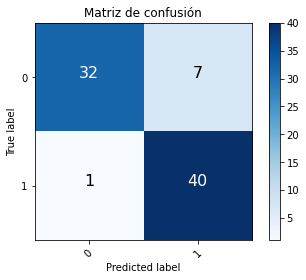

In [40]:
visualizar_confusion_matrix(y_test, modelo.predict(X_test))

En el gráfico se puede observar cómo se comporta el modelo para cada una de las clases. Se puede ver que el modelo está balanceado.

En este caso se observa que el modelo predice con una alta precisión las variables dado que, como se observa, casi la totalidad de los datos se encuentran en la diagonal principal (diagonal que contiene los "True Positives").

CURVA DE ROC Y DE PRECISION-RECALL

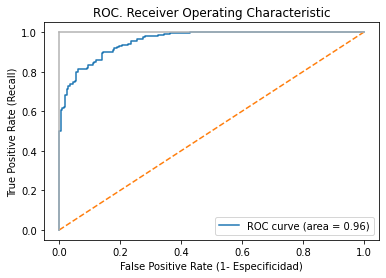

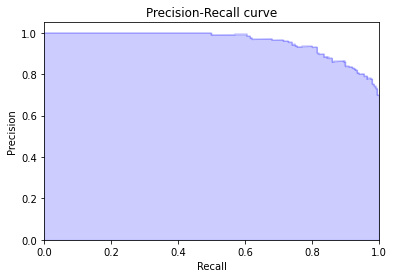

In [41]:
visualizar_curva_ROC(modelo, X, y)

La curva ROC nos dice qué tan bueno puede distinguir el modelo entre dos variables.

Un modelo ideal sería con una curva que cuente con un area de 1, en este caso, como indice el primer gráfico en la parte inferior derecha, cuanta con un área del 0.96, lo cual es muy bueno.

VISUALIZO LOS PARÁMETROS

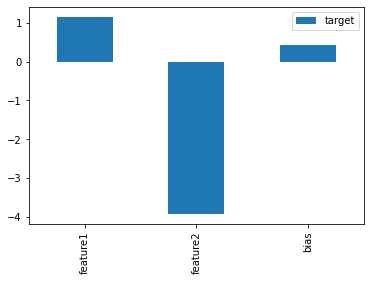

In [42]:
visualizar_parametros(modelo, mostrar_bias=True, feature_names=X.columns, target_name=y.name)

FRONTERA DE DECISIÓN DE DOS DIMENSIONES

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


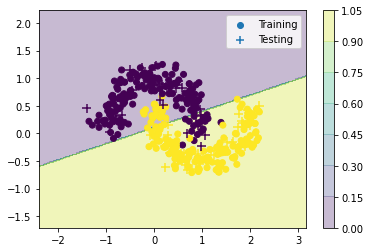

In [43]:
visualizar_frontera_de_desicion_2D(modelo, X, X_train, X_test, y_train, y_test)

FUNCION DE TRANSFERENCIA DE DOS DIMENSIONES

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


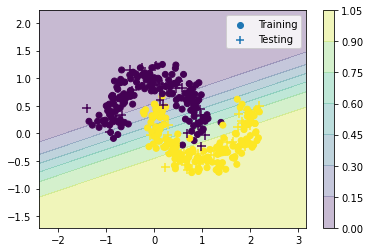

In [44]:
visualizar_funcion_transferencia_2D(modelo, X, X_train, X_test, y_train, y_test)